# Análise de Dados 🤖
Esse notebook apresenta nossas tentivas e observações iniciais sobre o modelo de dados. 

--- 

**Conteúdo deste notebook:**
1. Imports
1. Conectando com a base
1. Separação entre resposta e atributos
1. Separação entre treino e teste
1. Aplicando nos modelos


## Imports

In [172]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier

## Conectando com a base

In [173]:
df = pd.read_excel('../base/incluses_tratado.xlsx')

display(df.head(5))

,Participante da Comunidade LGBTQIA+,Faixa Etária,Identidade de Gênero,Orientação Sexual,Cidade/Estado,Escolaridade,Usa Apps para Oportunidades de Emprego?,Preferência de Cursos,Desafios de Emprego por Gênero,Interesse em Empreender,Situação no Mercado de Trabalho,Usa Redes Sociais?,Finalidade do Uso do App Incluses
0,Sim,Menos de 18 anos,Mulher cisgênero,Homossexual,Região Sudeste,Ensino Fundamental completo ou cursando,Sim,Prefiro cursos on-line,Sim,Não,Empregado (a),Sim,Todos acima
1,Sim,Menos de 18 anos,Mulher cisgênero,Homossexual,Região Sudeste,Ensino Fundamental completo ou cursando,Tenho interesse,"Não tenho preferência, pode ser on-line ou pre...",Sim,Não,Empregado (a),Sim,Não usaria o app
2,Sim,Menos de 18 anos,Mulher cisgênero,Pansexual,Região Norte,Ensino Fundamental completo ou cursando,Não,"Não tenho preferência, pode ser on-line ou pre...",Não,Talvez,Empregado (a),Sim,Fazer cursos de qualificação
3,Sim,Menos de 18 anos,Mulher cisgênero,Bissexual,Região Sudeste,Ensino Fundamental completo ou cursando,Não,"Não tenho preferência, pode ser on-line ou pre...",Sim,Não,Empregado (a),Sim,Não usaria o app
4,Sim,Menos de 18 anos,transgênero,Prefiro não informar,Região Sudeste,Nenhum,Não,"Não tenho preferência, pode ser on-line ou pre...",Sim,Sim,Desempregado (a),Sim,Fazer cursos de qualificação


## Separação de resposta e atributos

In [174]:
df_resposta = df['Finalidade do Uso do App Incluses']
df_atributo = df.iloc[:, :-1]

## Pré-processamento

### Transformando colunas quantitativas em qualitativas

In [175]:
#Resposta
label_encoder = LabelEncoder()

#Treino
preprocessador = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool'])),
    ],
    remainder='passthrough',
    verbose_feature_names_out= False 
)

# Aplicando o preprocessador nos atributos
df_atributo = pd.DataFrame(preprocessador.fit_transform(df_atributo), columns=preprocessador.get_feature_names_out())

## Definindo Pipeline incluindo SMOTE

In [176]:
# Definir o modelo base
model = RandomForestClassifier(random_state=42)

# Definir a pipeline incluindo o SMOTE e o modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=1)),
    ('classifier', model)
])

## GridSearchV

### Configurando Cross-validation 

In [177]:
# Validação cruzada estratificada
cv = KFold(n_splits=8)

### Configurando parâmetros para o GridSearchCV

In [178]:
# Definindo os classificadores
classifiers = {
    'knn': KNeighborsClassifier(),
    'naive_bayes': GaussianNB(),
    'decision_tree': DecisionTreeClassifier()
}

# Definindo o grid de hiperparâmetros para problemas multiclasse
param_grid = [
    {  # Parâmetros para KNeighborsClassifier
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': np.arange(1, 7, 1),
    },
    {  # Parâmetros para GaussianNB
        'classifier': [GaussianNB()],
        'classifier__priors': [None]
    },
    {  # Parâmetros para DecisionTreeClassifier
        'classifier': [DecisionTreeClassifier(random_state=12)],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 2, 4, 6, 8, 10, 12],
        'classifier__min_samples_split': [2, 5, 10, None],
        'classifier__min_samples_leaf': [1, 2, 5, 10, None],
        'classifier__max_features': [None, 'sqrt', 'log2'],
    }
]

### Definindo melhores parâmetros com GridSearchCV

In [179]:
# Variáveis para armazenar os melhores resultados para cada classificador
best_results = {
    'KNeighborsClassifier': {'best_test_size': None, 'best_score': -float('inf'), 'best_parameters': None},
    'GaussianNB': {'best_test_size': None, 'best_score': -float('inf'), 'best_parameters': None},
    'DecisionTreeClassifier': {'best_test_size': None, 'best_score': -float('inf'), 'best_parameters': None}
}

# Dividir o conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(df_atributo, df_resposta, test_size=0.25, random_state=42)

# Iterar sobre cada classificador e grid de hiperparâmetros
for grid in param_grid:

    # Ajustar o GridSearchCV
    grid_search = GridSearchCV(pipeline, grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Prever no conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Calcular a acurácia
    score = accuracy_score(y_test, y_pred)

    # Identificar o classificador utilizado
    classifier_name = grid_search.best_estimator_.named_steps['classifier'].__class__.__name__

    # Verificar se esta iteração tem o melhor resultado para este classificador
    if score > best_results[classifier_name]['best_score']:
        best_results[classifier_name]['best_score'] = score
        best_results[classifier_name]['best_test_size'] = 0.25
        best_results[classifier_name]['best_parameters'] = grid_search.best_params_


C:\Users\oliviadomingues-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oliviadomingues-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oliviadomingues-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Pytho

### Vendo melhores parâmetros

In [180]:
# Exibir os melhores resultados por modelo
for classifier, result in best_results.items():
    print(f"{classifier}: \nParâmetros = {result['best_parameters']}\n")

KNeighborsClassifier: 
Parâmetros = {'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 1}

GaussianNB: 
Parâmetros = {'classifier': GaussianNB(), 'classifier__priors': None}

DecisionTreeClassifier: 
Parâmetros = {'classifier': DecisionTreeClassifier(random_state=12), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}



## Balanceando classes com SMOTE

In [181]:
# Aplicando o smote
smote = SMOTE(random_state=42, k_neighbors=1)
df_atributo, df_resposta = smote.fit_resample(df_atributo, df_resposta)

#Descobindo o tamanho da base
print(f'Tamanho da base com SMOTE: {len(df_atributo)}')

Tamanho da base com SMOTE: 80


## Separando dados entre treino e teste

In [182]:
# Divida os dados em conjuntos de treino e teste
df_atributos_treino, df_atributos_teste, df_resposta_treino, df_resposta_teste = train_test_split(df_atributo, df_resposta, test_size=0.25, random_state=42)

# Converta para arrays
atributos_treino = df_atributos_treino.values
resposta_treino = df_resposta_treino.values
atributos_teste = df_atributos_teste.values
resposta_teste = df_resposta_teste.values

## Modelos

### DecisionTreeClassifier

#### Gini

##### Testando com valores de teste

Acurácia no conjunto de teste: 0.4500
                                    precision    recall  f1-score   support

 Divulgar conteúdos profissionais        1.00      0.33      0.50         3
Encontrar oportunidades de emprego       1.00      0.50      0.67         4
      Fazer cursos de qualificação       0.60      1.00      0.75         3
                  Não usaria o app       0.25      0.40      0.31         5
                       Todos acima       0.25      0.20      0.22         5

                          accuracy                           0.45        20
                         macro avg       0.62      0.49      0.49        20
                      weighted avg       0.57      0.45      0.45        20

Matriz de Confusão:
[[1 0 0 2 0]
 [0 2 0 1 1]
 [0 0 3 0 0]
 [0 0 1 2 2]
 [0 0 1 3 1]]


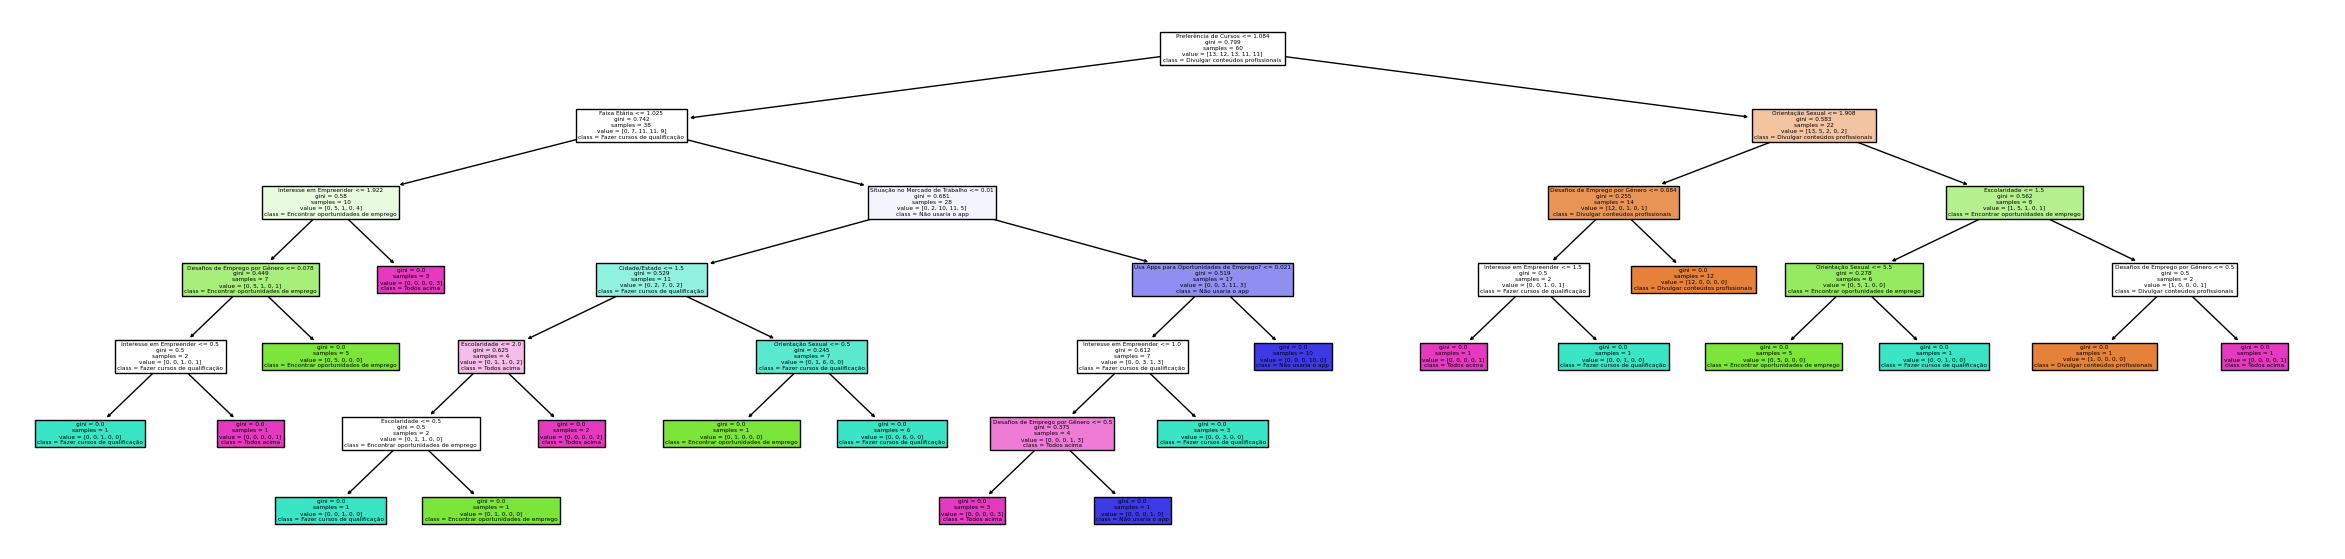

In [183]:
classificador_tree = tree.DecisionTreeClassifier(
        criterion='gini', 
        min_samples_leaf= 1,
        min_samples_split= 2,
        splitter= 'best'
    )

classificador_tree.fit(atributos_treino, resposta_treino)

# Faça previsões no conjunto de teste
previsoes = classificador_tree.predict(atributos_teste)

# Avalie o desempenho do modelo
acuracia = accuracy_score(resposta_teste, previsoes)
print(f'Acurácia no conjunto de teste: {acuracia:.4f}')

report_classificacao = classification_report(resposta_teste, previsoes)
print(report_classificacao)

matriz_de_confusao = confusion_matrix(resposta_teste, previsoes)
print("Matriz de Confusão:")
print(matriz_de_confusao)

plt.figure(figsize=(30,7))
tree.plot_tree(classificador_tree, feature_names=df_atributo.columns, class_names=classificador_tree.classes_, filled=True)
plt.show()

##### Testando com valores de treino

Acurácia no conjunto de treino: 1.0000
                                    precision    recall  f1-score   support

 Divulgar conteúdos profissionais        1.00      1.00      1.00        13
Encontrar oportunidades de emprego       1.00      1.00      1.00        12
      Fazer cursos de qualificação       1.00      1.00      1.00        13
                  Não usaria o app       1.00      1.00      1.00        11
                       Todos acima       1.00      1.00      1.00        11

                          accuracy                           1.00        60
                         macro avg       1.00      1.00      1.00        60
                      weighted avg       1.00      1.00      1.00        60

Matriz de Confusão:
[[13  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 13  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 11]]


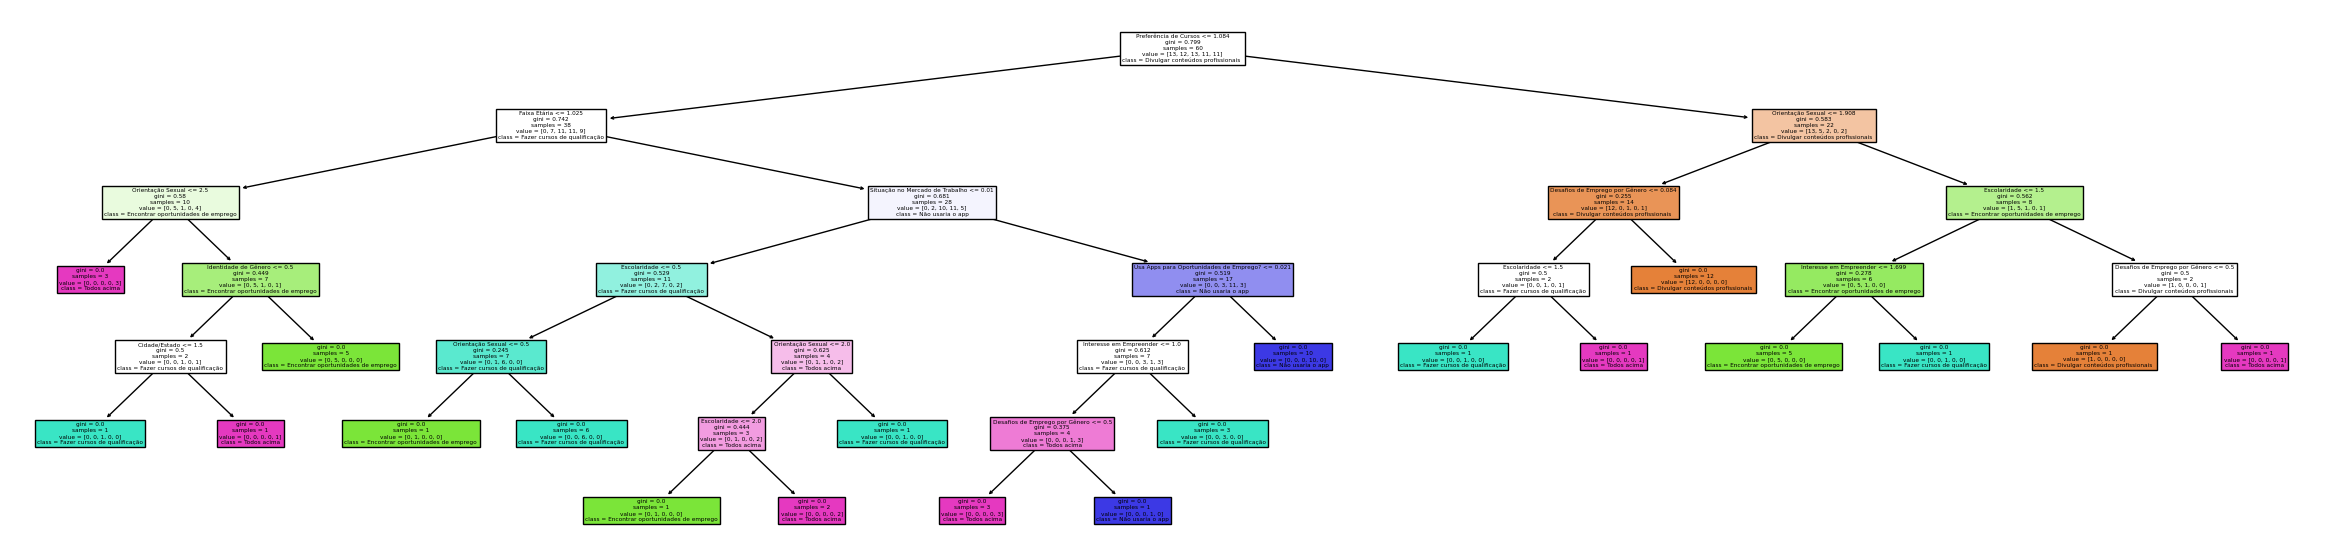

In [184]:
classificador_tree = tree.DecisionTreeClassifier(
        criterion='gini', 
        min_samples_leaf= 1,
        min_samples_split= 2,
        splitter= 'best'
    )

classificador_tree.fit(atributos_treino, resposta_treino)

# Faça previsões no conjunto de treino
previsoes = classificador_tree.predict(atributos_treino)

# Avalie o desempenho do modelo
acuracia = accuracy_score(resposta_treino, previsoes)
print(f'Acurácia no conjunto de treino: {acuracia:.4f}')

report_classificacao = classification_report(resposta_treino, previsoes)
print(report_classificacao)

matriz_de_confusao = confusion_matrix(resposta_treino, previsoes)
print("Matriz de Confusão:")
print(matriz_de_confusao)

plt.figure(figsize=(30,7))
tree.plot_tree(classificador_tree, feature_names=df_atributo.columns, class_names=classificador_tree.classes_, filled=True)
plt.show()

### KNeighborsClassifier

##### Testando com valores de teste

In [185]:
classificador_knn = KNeighborsClassifier(n_neighbors= 1)

classificador_knn.fit(atributos_treino, resposta_treino)

# Faça previsões no conjunto de teste
previsoes = classificador_knn.predict(atributos_teste)

# Avaliação do modelo
taxa_de_acerto = accuracy_score(resposta_teste, previsoes)
print("Taxa de acerto:", round(taxa_de_acerto * 100, 2))

report_classificacao = classification_report(resposta_teste, previsoes)
print(report_classificacao)

matriz_de_confusao = confusion_matrix(resposta_teste, previsoes)
print("Matriz de Confusão:")
print(matriz_de_confusao)

Taxa de acerto: 65.0
                                    precision    recall  f1-score   support

 Divulgar conteúdos profissionais        1.00      1.00      1.00         3
Encontrar oportunidades de emprego       1.00      1.00      1.00         4
      Fazer cursos de qualificação       0.50      0.33      0.40         3
                  Não usaria o app       0.43      0.60      0.50         5
                       Todos acima       0.50      0.40      0.44         5

                          accuracy                           0.65        20
                         macro avg       0.69      0.67      0.67        20
                      weighted avg       0.66      0.65      0.65        20

Matriz de Confusão:
[[3 0 0 0 0]
 [0 4 0 0 0]
 [0 0 1 2 0]
 [0 0 0 3 2]
 [0 0 1 2 2]]


##### Testando com valores de treino

In [186]:
classificador_knn = KNeighborsClassifier(n_neighbors= 1)

classificador_knn.fit(atributos_treino, resposta_treino)

# Faça previsões no conjunto de treino
previsoes = classificador_knn.predict(atributos_treino)

# Avaliação do modelo
taxa_de_acerto = accuracy_score(resposta_treino, previsoes)
print("Taxa de acerto:", round(taxa_de_acerto * 100, 2))

report_classificacao = classification_report(resposta_treino, previsoes)
print(report_classificacao)

matriz_de_confusao = confusion_matrix(resposta_treino, previsoes)
print("Matriz de Confusão:")
print(matriz_de_confusao)

Taxa de acerto: 100.0
                                    precision    recall  f1-score   support

 Divulgar conteúdos profissionais        1.00      1.00      1.00        13
Encontrar oportunidades de emprego       1.00      1.00      1.00        12
      Fazer cursos de qualificação       1.00      1.00      1.00        13
                  Não usaria o app       1.00      1.00      1.00        11
                       Todos acima       1.00      1.00      1.00        11

                          accuracy                           1.00        60
                         macro avg       1.00      1.00      1.00        60
                      weighted avg       1.00      1.00      1.00        60

Matriz de Confusão:
[[13  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 13  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 11]]


### GaussianNB

##### Testando com valores de teste

In [187]:

classificador_bayes = GaussianNB(priors=None)

classificador_bayes.fit(atributos_treino, resposta_treino)

# Faça previsões no conjunto de teste
previsoes = classificador_bayes.predict(atributos_teste)

# Avaliação do modelo
taxa_de_acerto = accuracy_score(resposta_teste, previsoes)
print("Taxa de acerto:", round(taxa_de_acerto * 100, 2))

report_classificacao = classification_report(resposta_teste, previsoes)
print(report_classificacao)

matriz_de_confusao = confusion_matrix(resposta_teste, previsoes)
print("Matriz de Confusão:")
print(matriz_de_confusao)

Taxa de acerto: 55.0
                                    precision    recall  f1-score   support

 Divulgar conteúdos profissionais        0.75      1.00      0.86         3
Encontrar oportunidades de emprego       0.38      0.75      0.50         4
      Fazer cursos de qualificação       0.60      1.00      0.75         3
                  Não usaria o app       1.00      0.40      0.57         5
                       Todos acima       0.00      0.00      0.00         5

                          accuracy                           0.55        20
                         macro avg       0.55      0.63      0.54        20
                      weighted avg       0.53      0.55      0.48        20

Matriz de Confusão:
[[3 0 0 0 0]
 [1 3 0 0 0]
 [0 0 3 0 0]
 [0 2 0 2 1]
 [0 3 2 0 0]]


##### Testando com valores de treino

In [188]:

classificador_bayes = GaussianNB(var_smoothing= 1.0)

classificador_bayes.fit(atributos_treino, resposta_treino)

# Faça previsões no conjunto de treino
previsoes = classificador_bayes.predict(atributos_treino)

# Avaliação do modelo
taxa_de_acerto = accuracy_score(resposta_treino, previsoes)
print("Taxa de acerto:", round(taxa_de_acerto * 100, 2))

report_classificacao = classification_report(resposta_treino, previsoes)
print(report_classificacao)

matriz_de_confusao = confusion_matrix(resposta_treino, previsoes)
print("Matriz de Confusão:")
print(matriz_de_confusao)

Taxa de acerto: 56.67
                                    precision    recall  f1-score   support

 Divulgar conteúdos profissionais        0.48      1.00      0.65        13
Encontrar oportunidades de emprego       0.56      0.75      0.64        12
      Fazer cursos de qualificação       0.80      0.31      0.44        13
                  Não usaria o app       0.57      0.36      0.44        11
                       Todos acima       0.80      0.36      0.50        11

                          accuracy                           0.57        60
                         macro avg       0.64      0.56      0.54        60
                      weighted avg       0.64      0.57      0.54        60

Matriz de Confusão:
[[13  0  0  0  0]
 [ 2  9  1  0  0]
 [ 6  1  4  1  1]
 [ 3  4  0  4  0]
 [ 3  2  0  2  4]]
